# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import os

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
# --- Preparazione dei Dati ---
# Standard MNIST transform. Normalizza i pixel e li converte in tensori PyTorch.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Carica i dataset MNIST.
print("Caricamento dataset MNIST...")
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Divide il dataset di training in training e validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

print(f"Dimensioni del dataset di training: {len(ds_train)} campioni")
print(f"Dimensioni del dataset di validation: {len(ds_val)} campioni")
print(f"Dimensioni del dataset di test: {len(ds_test)} campioni")

Caricamento dataset MNIST...
Dimensioni del dataset di training: 55000 campioni
Dimensioni del dataset di validation: 5000 campioni
Dimensioni del dataset di test: 10000 campioni


In [5]:
(ds_train.dataset.data / 255.0).std()

tensor(0.3081)

In [6]:
len(ds_train)

55000

In [7]:
len(ds_test)

10000

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [8]:
# Determina il device da usare (GPU se disponibile, altrimenti CPU).
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Utilizzando il device: {device}")

Utilizzando il device: cuda


In [9]:
# Creazione delle directory necessarie per i modelli e i log di TensorBoard
os.makedirs('./models', exist_ok=True)
os.makedirs('./runs', exist_ok=True)

In [10]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        # Appiattisce l'input da (batch_size, 1, 28, 28) a (batch_size, 784).
        x = x.flatten(1)

        # Applica gli strati: ReLU a tutti tranne l'ultimo.
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1: # Se non è l'ultimo strato
                x = F.relu(layer(x))
            else:
                x = layer(x) # L'ultimo strato non ha attivazione (perché F.cross_entropy include softmax)
        return x

In [ ]:
# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch_num, device='cpu'):
    model.train() # Imposta il modello in modalità training
    losses = []
    # tqdm fornisce una barra di progresso
    for xs, ys in tqdm(dl, desc=f'Training Epoch {epoch_num}', leave=False):
        xs = xs.to(device)
        ys = ys.to(device)

        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses) # Restituisce la loss media dell'epoca.

# Funzione per valutare il modello su un data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval() 
    predictions = []
    gts = [] 
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad(): # Disabilita il calcolo dei gradienti
        for xs, ys in tqdm(dl, desc='Evaluating', leave=False):
            xs = xs.to(device)
            ys = ys.to(device)

            logits = model(xs)
            loss = F.cross_entropy(logits, ys)
            total_loss += loss.item()
            num_batches += 1

            preds = torch.argmax(logits, dim=1)
            gts.append(ys.cpu().numpy())
            predictions.append(preds.cpu().numpy())

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    accuracy = accuracy_score(np.hstack(gts), np.hstack(predictions))
    report = classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3)

    return accuracy, report, avg_loss

# Funzione principale per addestrare e valutare un modello con TensorBoard
def train_and_evaluate_model(model_name, model, dl_train, dl_val, dl_test, epochs, lr, device, log_dir='./runs', model_save_dir='./models'):
    print(f"\n--- Inizio Addestramento per: {model_name} ---")
    writer = SummaryWriter(log_dir=os.path.join(log_dir, model_name))
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    best_val_accuracy = 0.0
    best_epoch = -1
    best_model_path = os.path.join(model_save_dir, f'{model_name}_best_model.pth')

    for epoch in range(epochs):
        
        # --- Fase di Training ---
        avg_train_loss = train_epoch(model, dl_train, optimizer, epoch + 1, device=device)
        history['train_loss'].append(avg_train_loss)
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)

        # --- Fase di Valutazione (Validation Set) ---
        val_accuracy, _, avg_val_loss = evaluate_model(model, dl_val, device=device)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Salva il modello migliore basato sull'accuratezza di validazione
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> Nuovo miglior modello salvato con accuratezza di validazione: {best_val_accuracy:.4f}")

    print(f"\n--- Addestramento completato per {model_name} ---")
    print(f"Miglior accuratezza di validazione: {best_val_accuracy:.4f} @ Epoch {best_epoch+1}")

    # --- Valutazione finale sul Test Set (con il modello migliore salvato) ---
    print(f"\n--- Valutazione finale sul Test Set per {model_name} ---")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        print("Caricato il modello migliore salvato per la valutazione finale.")
    else:
        print("Nessun modello salvato trovato. Valutando l'ultimo stato del modello.")

    test_accuracy, test_report, avg_test_loss = evaluate_model(model, dl_test, device=device)

    writer.add_scalar('Loss/Test', avg_test_loss, 0) # Log una sola volta
    writer.add_scalar('Accuracy/Test', test_accuracy, 0) # Log una sola volta

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Report di classificazione sul Test Set:\n{test_report}")

    writer.close()
    return history, test_accuracy, test_report

# Funzione per plottare le curve di training e validation per più modelli.
def plot_validation_curves_multiple(histories_dict):
    plt.figure(figsize=(16, 6))

    # Plot della Loss
    plt.subplot(1, 2, 1)
    for model_name, history in histories_dict.items():
        plt.plot(history['train_loss'], label=f'{model_name} Train Loss')
        plt.plot(history['val_loss'], label=f'{model_name} Val Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot dell'Accuratezza
    plt.subplot(1, 2, 2)
    for model_name, history in histories_dict.items():
        val_accs = history['val_accuracy']
        best_acc = np.max(val_accs)
        best_epoch = np.argmax(val_accs)
        plt.plot(val_accs, label=f'{model_name} Val Acc (Best: {best_acc:.3f} @ Epoch {best_epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

commento: Per fare implementazione minima di un multipayer perceptron

In [12]:
foo = MLP([28*28, 64, 64, 10])
foo

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [13]:
list(foo.parameters())

[Parameter containing:
 tensor([[ 0.0122,  0.0061, -0.0232,  ...,  0.0145,  0.0075, -0.0135],
         [ 0.0133,  0.0256, -0.0195,  ..., -0.0225, -0.0162,  0.0126],
         [-0.0114,  0.0216, -0.0348,  ..., -0.0219,  0.0234, -0.0200],
         ...,
         [-0.0353, -0.0351, -0.0342,  ...,  0.0243,  0.0052,  0.0221],
         [ 0.0095, -0.0025,  0.0140,  ...,  0.0113, -0.0355, -0.0078],
         [ 0.0342, -0.0151,  0.0053,  ...,  0.0012, -0.0108,  0.0061]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0134, -0.0335, -0.0221,  0.0059, -0.0041,  0.0128, -0.0054,  0.0254,
         -0.0094, -0.0078, -0.0036,  0.0203, -0.0297,  0.0340, -0.0007,  0.0022,
          0.0313,  0.0076,  0.0275, -0.0122,  0.0026,  0.0229, -0.0013,  0.0339,
         -0.0208, -0.0204,  0.0296, -0.0296, -0.0283, -0.0172, -0.0177,  0.0108,
         -0.0120, -0.0307,  0.0294, -0.0276,  0.0127, -0.0350,  0.0029, -0.0282,
          0.0332,  0.0155, -0.0035, -0.0106,  0.0113,  0.0273,  0.0233, -0.0151

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

Commento: Le residual connection vanno fatte a gruppi di due layer con la stessa dimensione.

## Using TensorBoard to monitor training

Instead of generating plots inline like above, it is generally better to use something like [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) or [Comet](https://www.comet.com/site/) or [Weights and Biases](https://wandb.ai/site/) to track training runs. Here is a simple toplevel training loop that logs training loss and validation accuracy. To run the TensorBoard webapp you must run (in the same directory where the `runs/` directory is created):

    tensorboard --logdir=./runs


The code below will perform three training runs for different depths of MLPs. The results can be plotted and compared in the TensorBoard interface.


--- Preparazione Modello di Baseline: MLP_Baseline_W32_D2_LR0.0001_BS256_Seed1023 ---
Avvio addestramento e valutazione per il modello di baseline...

--- Inizio Addestramento per: MLP_Baseline_W32_D2_LR0.0001_BS256_Seed1023 ---


Epoch 1/20: Train Loss: 1.7689, Val Loss: 1.1180, Val Acc: 0.7768
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7768


Epoch 2/20: Train Loss: 0.7825, Val Loss: 0.5722, Val Acc: 0.8584
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8584


Epoch 3/20: Train Loss: 0.4919, Val Loss: 0.4347, Val Acc: 0.8824
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8824


Epoch 4/20: Train Loss: 0.3980, Val Loss: 0.3749, Val Acc: 0.8934
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8934


Epoch 5/20: Train Loss: 0.3521, Val Loss: 0.3426, Val Acc: 0.9010
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9010


Epoch 6/20: Train Loss: 0.3240, Val Loss: 0.3202, Val Acc: 0.9066
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9066


Epoch 7/20: Train Loss: 0.3044, Val Loss: 0.3053, Val Acc: 0.9108
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9108


Epoch 8/20: Train Loss: 0.2893, Val Loss: 0.2934, Val Acc: 0.9144
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9144


Epoch 9/20: Train Loss: 0.2770, Val Loss: 0.2840, Val Acc: 0.9180
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9180


Epoch 10/20: Train Loss: 0.2672, Val Loss: 0.2758, Val Acc: 0.9204
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9204


Epoch 11/20: Train Loss: 0.2586, Val Loss: 0.2698, Val Acc: 0.9204


Epoch 12/20: Train Loss: 0.2510, Val Loss: 0.2641, Val Acc: 0.9228
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9228


Epoch 13/20: Train Loss: 0.2437, Val Loss: 0.2584, Val Acc: 0.9240
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9240


Epoch 14/20: Train Loss: 0.2372, Val Loss: 0.2528, Val Acc: 0.9264
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9264


Epoch 15/20: Train Loss: 0.2312, Val Loss: 0.2490, Val Acc: 0.9282
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9282


Epoch 16/20: Train Loss: 0.2252, Val Loss: 0.2437, Val Acc: 0.9286
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9286


Epoch 17/20: Train Loss: 0.2200, Val Loss: 0.2397, Val Acc: 0.9292
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9292


Epoch 18/20: Train Loss: 0.2149, Val Loss: 0.2353, Val Acc: 0.9316
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9316


Epoch 19/20: Train Loss: 0.2101, Val Loss: 0.2322, Val Acc: 0.9330
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9330


Epoch 20/20: Train Loss: 0.2053, Val Loss: 0.2269, Val Acc: 0.9348
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9348

--- Addestramento completato per MLP_Baseline_W32_D2_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9348 @ Epoch 20

--- Valutazione finale sul Test Set per MLP_Baseline_W32_D2_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.2081, Test Accuracy: 0.9397
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.958     0.983     0.970       980
           1      0.972     0.983     0.978      1135
           2      0.946     0.925     0.936      1032
           3      0.921     0.930     0.926      1010
           4      0.931     0.948     0.939       982
           5      0.928     0.902     0.915       892
           6      0.936     0.959     0.947       958
           7      0.952     0.925     0.938      1028
           8      0.913     0.908     0.910       974
           9      0.931     0.926     0.928      1009

    accuracy                          0.940     10000
   macro avg      0.939     0.939     0.939     10000
weighted avg      0.940     0.940     0.940     10000


--- Generazione dei grafici per la Baseline MLP ---


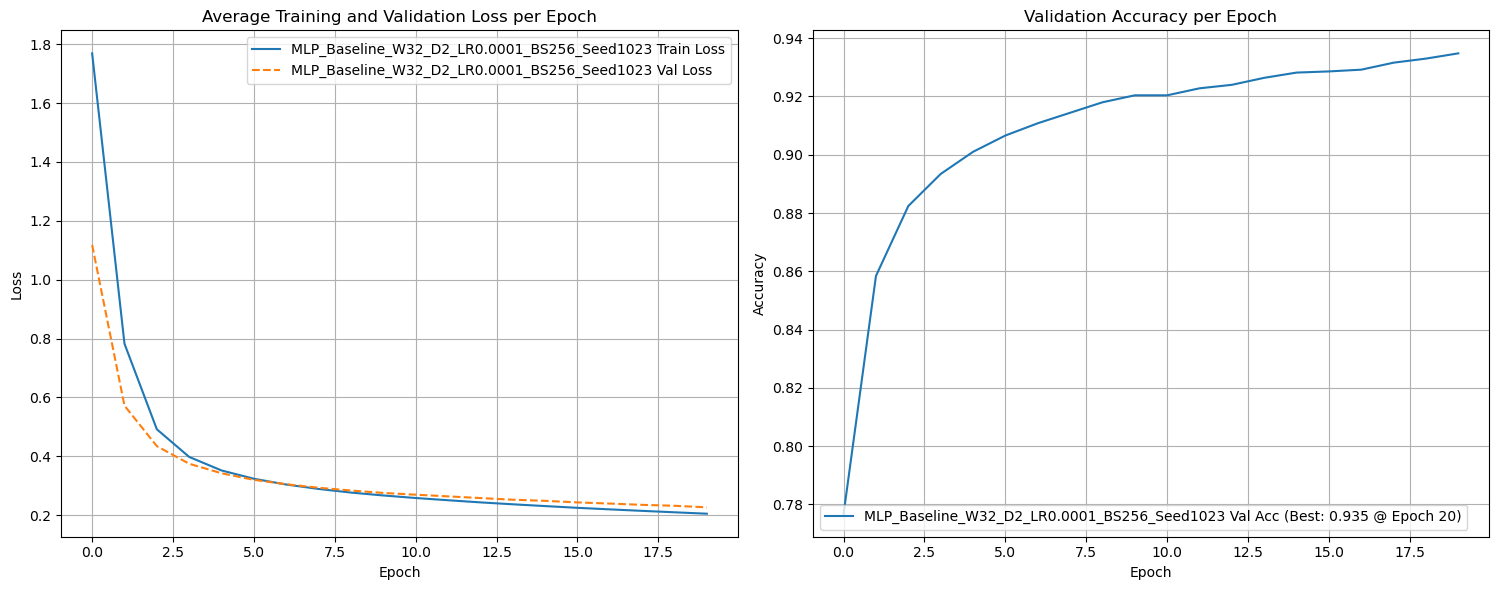


--- Riepilogo finale delle performance per la Baseline MLP ---
Modello: MLP_Baseline_W32_D2_LR0.0001_BS256_Seed1023
Miglior accuratezza di validazione raggiunta: 0.9348
Accuratezza finale sul Test Set (usando il miglior modello di validazione): 0.9397
Report di classificazione completo sul Test Set:
              precision    recall  f1-score   support

           0      0.958     0.983     0.970       980
           1      0.972     0.983     0.978      1135
           2      0.946     0.925     0.936      1032
           3      0.921     0.930     0.926      1010
           4      0.931     0.948     0.939       982
           5      0.928     0.902     0.915       892
           6      0.936     0.959     0.947       958
           7      0.952     0.925     0.938      1028
           8      0.913     0.908     0.910       974
           9      0.931     0.926     0.928      1009

    accuracy                          0.940     10000
   macro avg      0.939     0.939     0.939     

In [ ]:
epochs = 20
lr = 0.0001
batch_size = 256
seed = 1023

torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

input_size = 28 * 28 # L'input per una MLP da immagini MNIST (28x28 = 784 pixel).
num_classes = 10     # Numero di classi di output (le 10 cifre da 0 a 9).

# Dataloaders: preparano i dati in batch per il training e la valutazione.
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size, num_workers=4, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Dizionari per memorizzare la storia di training/validazione e i report di test
# di tutti i modelli che addestrerai. Per l'Esercizio 1.1 avranno solo la baseline.
all_model_histories = {}
all_test_reports = {}

# --- Configurazione Specifica per la MLP di Baseline ---

width_baseline = 32 
depth_baseline = 2  # Due strati nascosti.

# Crea un nome identificativo unico per il tuo modello di baseline.
model_name_baseline = f'MLP_Baseline_W{width_baseline}_D{depth_baseline}_LR{lr}_BS{batch_size}_Seed{seed}'
print(f"\n--- Preparazione Modello di Baseline: {model_name_baseline} ---")

layer_sizes_baseline = [input_size] + [width_baseline] * depth_baseline + [num_classes]
model_baseline = MLP(layer_sizes_baseline) # Istanzia il modello MLP generico con le dimensioni definite.

# --- Esegui la Pipeline di Addestramento e Valutazione per il Modello di Baseline ---
print("Avvio addestramento e valutazione per il modello di baseline...")
history_baseline, test_accuracy_baseline, test_report_baseline = train_and_evaluate_model(
    model_name=model_name_baseline,
    model=model_baseline,
    dl_train=dl_train,
    dl_val=dl_val,
    dl_test=dl_test,
    epochs=epochs,
    lr=lr,
    device=device,
    log_dir='./runs',
    model_save_dir='./models'
)

# Salva la storia di training/validazione e i report di test del modello di baseline.
all_model_histories[model_name_baseline] = history_baseline
all_test_reports[model_name_baseline] = {"accuracy": test_accuracy_baseline, "report": test_report_baseline}

# --- Plot delle curve di performance per la Baseline MLP ---

print("\n--- Generazione dei grafici per la Baseline MLP ---")
plot_validation_curves_multiple({model_name_baseline: history_baseline})

print("\n--- Riepilogo finale delle performance per la Baseline MLP ---")
print(f"Modello: {model_name_baseline}")
print(f"Miglior accuratezza di validazione raggiunta: {np.max(history_baseline['val_accuracy']):.4f}")
print(f"Accuratezza finale sul Test Set (usando il miglior modello di validazione): {test_accuracy_baseline:.4f}")
print(f"Report di classificazione completo sul Test Set:\n{test_report_baseline}")


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case.


In [ ]:
class ResMLPBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc1 = nn.Linear(width, width)
        self.fc2 = nn.Linear(width, width)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return out + x

class ResMLP(nn.Module):
    def __init__(self, input_size, inner_size, num_blocks, output_size):
        super().__init__()
        self.input_adapter = nn.Linear(input_size, inner_size)
        self.blocks = nn.Sequential(*([ResMLPBlock(inner_size)] * num_blocks))  
        self.output_adapter = nn.Linear(inner_size, output_size)

    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.input_adapter(x))
        x = self.blocks(x)
        return self.output_adapter(x)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 20
lr = 0.0001
batch_size = 256
seed = 1023
torch.manual_seed(seed)

torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

input_size = 28 * 28
num_classes = 10

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size, num_workers=4, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) 

# --- Definizione degli Esperimenti per il Confronto ---
# Useremo i dizionari per raccogliere i risultati di tutti i modelli per il plotting finale.

all_model_histories = {}
all_test_reports = {}

# Larghezza degli strati (width) per ResMLP e MLP.

width = 32

In [ ]:
# Esempi di profondità dei blocchi per ResMLP:
res_depths_blocks = [1, 2, 5, 10] # Numero di blocchi residui

print("\n--- Esecuzione degli esperimenti per ResMLP ---")
for num_blocks in res_depths_blocks:

    # Calcola la profondità totale degli strati lineari per ResMLP (2 per blocco + 2 per adattatori)
    total_res_layers = (num_blocks * 2) + 2
    model_name_res = f'ResMLP_W{width}_Blocks{num_blocks}_TotalLayers{total_res_layers}_LR{lr}_BS{batch_size}_Seed{seed}'
    print(f"\n--- Preparazione Modello: {model_name_res} ---")

    model_res = ResMLP(input_size, width, num_blocks, num_classes)

    history_res, test_accuracy_res, test_report_res = train_and_evaluate_model(
        model_name=model_name_res,
        model=model_res,
        dl_train=dl_train,
        dl_val=dl_val,
        dl_test=dl_test,
        epochs=epochs,
        lr=lr,
        device=device,
        log_dir='./runs',
        model_save_dir='./models'
    )
    all_model_histories[model_name_res] = history_res
    all_test_reports[model_name_res] = {"accuracy": test_accuracy_res, "report": test_report_res}


print("\n--- Esecuzione degli esperimenti per MLP (Senza Connessioni Residue) ---")

for num_blocks in res_depths_blocks:
    total_hidden_layers_mlp = (num_blocks * 2)
    if total_hidden_layers_mlp == 0: 
        continue

    # Crea un nome descrittivo per la MLP normale corrispondente.
    model_name_mlp = f'MLP_W{width}_HiddenLayers{total_hidden_layers_mlp}_LR{lr}_BS{batch_size}_Seed{seed}'
    print(f"\n--- Preparazione Modello: {model_name_mlp} ---")

    layer_sizes_mlp = [input_size] + [width] * total_hidden_layers_mlp + [num_classes]
    model_mlp = MLP(layer_sizes_mlp) # Usa la classe MLP definita nel codice base

    history_mlp, test_accuracy_mlp, test_report_mlp = train_and_evaluate_model(
        model_name=model_name_mlp,
        model=model_mlp,
        dl_train=dl_train,
        dl_val=dl_val,
        dl_test=dl_test,
        epochs=epochs,
        lr=lr,
        device=device,
        log_dir='./runs',
        model_save_dir='./models'
    )
    all_model_histories[model_name_mlp] = history_mlp
    all_test_reports[model_name_mlp] = {"accuracy": test_accuracy_mlp, "report": test_report_mlp}



--- Esecuzione degli esperimenti per ResMLP ---

--- Preparazione Modello: ResMLP_W32_Blocks1_TotalLayers4_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: ResMLP_W32_Blocks1_TotalLayers4_LR0.0001_BS256_Seed1023 ---


Epoch 1/20: Train Loss: 1.4558, Val Loss: 0.8127, Val Acc: 0.8176
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8176


Epoch 2/20: Train Loss: 0.6146, Val Loss: 0.4930, Val Acc: 0.8758
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8758


Epoch 3/20: Train Loss: 0.4314, Val Loss: 0.3942, Val Acc: 0.8940
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8940


Epoch 4/20: Train Loss: 0.3607, Val Loss: 0.3481, Val Acc: 0.9038
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9038


Epoch 5/20: Train Loss: 0.3228, Val Loss: 0.3199, Val Acc: 0.9120
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9120


Epoch 6/20: Train Loss: 0.2988, Val Loss: 0.3018, Val Acc: 0.9154
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9154


Epoch 7/20: Train Loss: 0.2812, Val Loss: 0.2879, Val Acc: 0.9188
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9188


Epoch 8/20: Train Loss: 0.2671, Val Loss: 0.2766, Val Acc: 0.9208
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9208


Epoch 9/20: Train Loss: 0.2551, Val Loss: 0.2660, Val Acc: 0.9248
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9248


Epoch 10/20: Train Loss: 0.2444, Val Loss: 0.2583, Val Acc: 0.9272
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9272


Epoch 11/20: Train Loss: 0.2349, Val Loss: 0.2517, Val Acc: 0.9286
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9286


Epoch 12/20: Train Loss: 0.2266, Val Loss: 0.2450, Val Acc: 0.9326
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9326


Epoch 13/20: Train Loss: 0.2188, Val Loss: 0.2350, Val Acc: 0.9356
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9356


Epoch 14/20: Train Loss: 0.2115, Val Loss: 0.2293, Val Acc: 0.9346


Epoch 15/20: Train Loss: 0.2045, Val Loss: 0.2244, Val Acc: 0.9364
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9364


Epoch 16/20: Train Loss: 0.1984, Val Loss: 0.2193, Val Acc: 0.9364


Epoch 17/20: Train Loss: 0.1928, Val Loss: 0.2172, Val Acc: 0.9390
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9390


Epoch 18/20: Train Loss: 0.1871, Val Loss: 0.2098, Val Acc: 0.9398
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9398


Epoch 19/20: Train Loss: 0.1819, Val Loss: 0.2050, Val Acc: 0.9408
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9408


Epoch 20/20: Train Loss: 0.1772, Val Loss: 0.1998, Val Acc: 0.9424
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9424

--- Addestramento completato per ResMLP_W32_Blocks1_TotalLayers4_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9424 @ Epoch 20

--- Valutazione finale sul Test Set per ResMLP_W32_Blocks1_TotalLayers4_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.1821, Test Accuracy: 0.9448
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.957     0.982     0.969       980
           1      0.975     0.985     0.980      1135
           2      0.941     0.931     0.936      1032
           3      0.930     0.931     0.930      1010
           4      0.946     0.950     0.948       982
           5      0.939     0.923     0.931       892
           6      0.943     0.959     0.951       958
           7      0.952     0.934     0.943      1028
           8      0.922     0.928     0.925       974
           9      0.937     0.920     0.928      1009

    accuracy                          0.945     10000
   macro avg      0.944     0.944     0.944     10000
weighted avg      0.945     0.945     0.945     10000


--- Preparazione Modello: ResMLP_W32_Blocks2_TotalLayers6_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: ResMLP_W32_Blocks2_TotalLayers6_LR0.0001_B

Epoch 1/20: Train Loss: 1.4001, Val Loss: 0.7354, Val Acc: 0.8202
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8202


Epoch 2/20: Train Loss: 0.5579, Val Loss: 0.4557, Val Acc: 0.8724
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8724


Epoch 3/20: Train Loss: 0.3960, Val Loss: 0.3660, Val Acc: 0.8966
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8966


Epoch 4/20: Train Loss: 0.3313, Val Loss: 0.3214, Val Acc: 0.9068
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9068


Epoch 5/20: Train Loss: 0.2950, Val Loss: 0.2948, Val Acc: 0.9158
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9158


Epoch 6/20: Train Loss: 0.2707, Val Loss: 0.2770, Val Acc: 0.9176
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9176


Epoch 7/20: Train Loss: 0.2531, Val Loss: 0.2634, Val Acc: 0.9224
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9224


Epoch 8/20: Train Loss: 0.2386, Val Loss: 0.2525, Val Acc: 0.9272
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9272


Epoch 9/20: Train Loss: 0.2270, Val Loss: 0.2422, Val Acc: 0.9302
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9302


Epoch 10/20: Train Loss: 0.2167, Val Loss: 0.2363, Val Acc: 0.9298


Epoch 11/20: Train Loss: 0.2078, Val Loss: 0.2323, Val Acc: 0.9324
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9324


Epoch 12/20: Train Loss: 0.1998, Val Loss: 0.2221, Val Acc: 0.9354
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9354


Epoch 13/20: Train Loss: 0.1921, Val Loss: 0.2153, Val Acc: 0.9382
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9382


Epoch 14/20: Train Loss: 0.1851, Val Loss: 0.2104, Val Acc: 0.9382


Epoch 15/20: Train Loss: 0.1784, Val Loss: 0.2053, Val Acc: 0.9414
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9414


Epoch 16/20: Train Loss: 0.1727, Val Loss: 0.2002, Val Acc: 0.9422
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9422


Epoch 17/20: Train Loss: 0.1668, Val Loss: 0.1944, Val Acc: 0.9452
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9452


Epoch 18/20: Train Loss: 0.1617, Val Loss: 0.1927, Val Acc: 0.9464
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9464


Epoch 19/20: Train Loss: 0.1570, Val Loss: 0.1883, Val Acc: 0.9448


Epoch 20/20: Train Loss: 0.1519, Val Loss: 0.1845, Val Acc: 0.9452

--- Addestramento completato per ResMLP_W32_Blocks2_TotalLayers6_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9464 @ Epoch 18

--- Valutazione finale sul Test Set per ResMLP_W32_Blocks2_TotalLayers6_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.1735, Test Accuracy: 0.9489
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.963     0.986     0.974       980
           1      0.967     0.989     0.978      1135
           2      0.942     0.952     0.947      1032
           3      0.934     0.932     0.933      1010
           4      0.952     0.948     0.950       982
           5      0.940     0.917     0.928       892
           6      0.954     0.954     0.954       958
           7      0.961     0.946     0.953      1028
           8      0.931     0.925     0.928       974
           9      0.940     0.934     0.937      1009

    accuracy                          0.949     10000
   macro avg      0.948     0.948     0.948     10000
weighted avg      0.949     0.949     0.949     10000


--- Preparazione Modello: ResMLP_W32_Blocks5_TotalLayers12_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: ResMLP_W32_Blocks5_TotalLayers12_LR0.0001

Epoch 1/20: Train Loss: 1.4041, Val Loss: 0.7170, Val Acc: 0.8184
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8184


Epoch 2/20: Train Loss: 0.5040, Val Loss: 0.3991, Val Acc: 0.8864
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8864


Epoch 3/20: Train Loss: 0.3414, Val Loss: 0.3211, Val Acc: 0.9046
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9046


Epoch 4/20: Train Loss: 0.2860, Val Loss: 0.2806, Val Acc: 0.9168
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9168


Epoch 5/20: Train Loss: 0.2532, Val Loss: 0.2539, Val Acc: 0.9242
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9242


Epoch 6/20: Train Loss: 0.2300, Val Loss: 0.2363, Val Acc: 0.9294
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9294


Epoch 7/20: Train Loss: 0.2126, Val Loss: 0.2250, Val Acc: 0.9356
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9356


Epoch 8/20: Train Loss: 0.1986, Val Loss: 0.2129, Val Acc: 0.9386
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9386


Epoch 9/20: Train Loss: 0.1868, Val Loss: 0.2036, Val Acc: 0.9420
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9420


Epoch 10/20: Train Loss: 0.1766, Val Loss: 0.1971, Val Acc: 0.9446
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9446


Epoch 11/20: Train Loss: 0.1677, Val Loss: 0.1907, Val Acc: 0.9464
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9464


Epoch 12/20: Train Loss: 0.1600, Val Loss: 0.1861, Val Acc: 0.9482
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9482


Epoch 13/20: Train Loss: 0.1533, Val Loss: 0.1811, Val Acc: 0.9490
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9490


Epoch 14/20: Train Loss: 0.1469, Val Loss: 0.1784, Val Acc: 0.9514
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9514


Epoch 15/20: Train Loss: 0.1409, Val Loss: 0.1700, Val Acc: 0.9520
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9520


Epoch 16/20: Train Loss: 0.1347, Val Loss: 0.1700, Val Acc: 0.9492


Epoch 17/20: Train Loss: 0.1306, Val Loss: 0.1652, Val Acc: 0.9544
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9544


Epoch 18/20: Train Loss: 0.1253, Val Loss: 0.1649, Val Acc: 0.9536


Epoch 19/20: Train Loss: 0.1213, Val Loss: 0.1597, Val Acc: 0.9528


Epoch 20/20: Train Loss: 0.1176, Val Loss: 0.1558, Val Acc: 0.9570
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9570

--- Addestramento completato per ResMLP_W32_Blocks5_TotalLayers12_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9570 @ Epoch 20

--- Valutazione finale sul Test Set per ResMLP_W32_Blocks5_TotalLayers12_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.1349, Test Accuracy: 0.9585
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.972     0.984     0.978       980
           1      0.981     0.984     0.982      1135
           2      0.966     0.953     0.959      1032
           3      0.926     0.960     0.943      1010
           4      0.952     0.963     0.957       982
           5      0.958     0.944     0.951       892
           6      0.952     0.963     0.957       958
           7      0.964     0.957     0.960      1028
           8      0.952     0.937     0.945       974
           9      0.961     0.935     0.948      1009

    accuracy                          0.959     10000
   macro avg      0.958     0.958     0.958     10000
weighted avg      0.959     0.959     0.958     10000


--- Preparazione Modello: ResMLP_W32_Blocks10_TotalLayers22_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: ResMLP_W32_Blocks10_TotalLayers22_LR0.00

Epoch 1/20: Train Loss: 1.4915, Val Loss: 0.6630, Val Acc: 0.8288
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8288


Epoch 2/20: Train Loss: 0.4528, Val Loss: 0.3662, Val Acc: 0.8970
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8970


Epoch 3/20: Train Loss: 0.3194, Val Loss: 0.3114, Val Acc: 0.9122
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9122


Epoch 4/20: Train Loss: 0.2678, Val Loss: 0.2752, Val Acc: 0.9212
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9212


Epoch 5/20: Train Loss: 0.2341, Val Loss: 0.2487, Val Acc: 0.9284
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9284


Epoch 6/20: Train Loss: 0.2103, Val Loss: 0.2354, Val Acc: 0.9334
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9334


Epoch 7/20: Train Loss: 0.1929, Val Loss: 0.2148, Val Acc: 0.9386
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9386


Epoch 8/20: Train Loss: 0.1809, Val Loss: 0.2051, Val Acc: 0.9422
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9422


Epoch 9/20: Train Loss: 0.1697, Val Loss: 0.1965, Val Acc: 0.9470
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9470


Epoch 10/20: Train Loss: 0.1604, Val Loss: 0.1931, Val Acc: 0.9450


Epoch 11/20: Train Loss: 0.1524, Val Loss: 0.1828, Val Acc: 0.9468


Epoch 12/20: Train Loss: 0.1447, Val Loss: 0.1791, Val Acc: 0.9502
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9502


Epoch 13/20: Train Loss: 0.1395, Val Loss: 0.1743, Val Acc: 0.9514
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9514


Epoch 14/20: Train Loss: 0.1324, Val Loss: 0.1715, Val Acc: 0.9526
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9526


Epoch 15/20: Train Loss: 0.1273, Val Loss: 0.1730, Val Acc: 0.9508


Epoch 16/20: Train Loss: 0.1235, Val Loss: 0.1639, Val Acc: 0.9554
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9554


Epoch 17/20: Train Loss: 0.1179, Val Loss: 0.1634, Val Acc: 0.9554


Epoch 18/20: Train Loss: 0.1149, Val Loss: 0.1603, Val Acc: 0.9568
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9568


Epoch 19/20: Train Loss: 0.1095, Val Loss: 0.1599, Val Acc: 0.9554


Epoch 20/20: Train Loss: 0.1064, Val Loss: 0.1572, Val Acc: 0.9564

--- Addestramento completato per ResMLP_W32_Blocks10_TotalLayers22_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9568 @ Epoch 18

--- Valutazione finale sul Test Set per ResMLP_W32_Blocks10_TotalLayers22_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.1448, Test Accuracy: 0.9546
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.961     0.981     0.971       980
           1      0.980     0.983     0.982      1135
           2      0.962     0.945     0.954      1032
           3      0.929     0.950     0.940      1010
           4      0.969     0.968     0.969       982
           5      0.919     0.941     0.930       892
           6      0.960     0.953     0.957       958
           7      0.952     0.954     0.953      1028
           8      0.947     0.928     0.937       974
           9      0.960     0.938     0.949      1009

    accuracy                          0.955     10000
   macro avg      0.954     0.954     0.954     10000
weighted avg      0.955     0.955     0.955     10000


--- Esecuzione degli esperimenti per MLP (Senza Connessioni Residue) ---

--- Preparazione Modello: MLP_W32_HiddenLayers2_LR0.0001_BS256_Seed1023 ---

--- Iniz

Epoch 1/20: Train Loss: 1.7506, Val Loss: 1.0984, Val Acc: 0.7910
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7910


Epoch 2/20: Train Loss: 0.7774, Val Loss: 0.5799, Val Acc: 0.8614
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8614


Epoch 3/20: Train Loss: 0.4893, Val Loss: 0.4387, Val Acc: 0.8856
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8856


Epoch 4/20: Train Loss: 0.3944, Val Loss: 0.3808, Val Acc: 0.8960
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8960


Epoch 5/20: Train Loss: 0.3484, Val Loss: 0.3465, Val Acc: 0.9040
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9040


Epoch 6/20: Train Loss: 0.3198, Val Loss: 0.3246, Val Acc: 0.9082
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9082


Epoch 7/20: Train Loss: 0.2997, Val Loss: 0.3087, Val Acc: 0.9140
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9140


Epoch 8/20: Train Loss: 0.2841, Val Loss: 0.2941, Val Acc: 0.9166
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9166


Epoch 9/20: Train Loss: 0.2712, Val Loss: 0.2844, Val Acc: 0.9186
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9186


Epoch 10/20: Train Loss: 0.2606, Val Loss: 0.2752, Val Acc: 0.9220
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9220


Epoch 11/20: Train Loss: 0.2515, Val Loss: 0.2676, Val Acc: 0.9262
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9262


Epoch 12/20: Train Loss: 0.2431, Val Loss: 0.2592, Val Acc: 0.9254


Epoch 13/20: Train Loss: 0.2359, Val Loss: 0.2530, Val Acc: 0.9292
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9292


Epoch 14/20: Train Loss: 0.2292, Val Loss: 0.2478, Val Acc: 0.9290


Epoch 15/20: Train Loss: 0.2228, Val Loss: 0.2415, Val Acc: 0.9316
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9316


Epoch 16/20: Train Loss: 0.2170, Val Loss: 0.2359, Val Acc: 0.9320
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9320


Epoch 17/20: Train Loss: 0.2117, Val Loss: 0.2312, Val Acc: 0.9350
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9350


Epoch 18/20: Train Loss: 0.2067, Val Loss: 0.2265, Val Acc: 0.9366
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9366


Epoch 19/20: Train Loss: 0.2023, Val Loss: 0.2227, Val Acc: 0.9346


Epoch 20/20: Train Loss: 0.1975, Val Loss: 0.2178, Val Acc: 0.9372
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9372

--- Addestramento completato per MLP_W32_HiddenLayers2_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9372 @ Epoch 20

--- Valutazione finale sul Test Set per MLP_W32_HiddenLayers2_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.1980, Test Accuracy: 0.9421
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.961     0.982     0.971       980
           1      0.970     0.981     0.975      1135
           2      0.938     0.933     0.935      1032
           3      0.926     0.931     0.928      1010
           4      0.931     0.949     0.940       982
           5      0.934     0.914     0.924       892
           6      0.943     0.955     0.949       958
           7      0.952     0.933     0.943      1028
           8      0.931     0.913     0.922       974
           9      0.929     0.925     0.927      1009

    accuracy                          0.942     10000
   macro avg      0.942     0.941     0.941     10000
weighted avg      0.942     0.942     0.942     10000


--- Preparazione Modello: MLP_W32_HiddenLayers4_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: MLP_W32_HiddenLayers4_LR0.0001_BS256_Seed1023 ---


Epoch 1/20: Train Loss: 2.1286, Val Loss: 1.7015, Val Acc: 0.4806
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.4806


Epoch 2/20: Train Loss: 1.1831, Val Loss: 0.7934, Val Acc: 0.7702
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7702


Epoch 3/20: Train Loss: 0.6201, Val Loss: 0.5294, Val Acc: 0.8400
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8400


Epoch 4/20: Train Loss: 0.4539, Val Loss: 0.4233, Val Acc: 0.8752
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8752


Epoch 5/20: Train Loss: 0.3804, Val Loss: 0.3740, Val Acc: 0.8884
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8884


Epoch 6/20: Train Loss: 0.3418, Val Loss: 0.3445, Val Acc: 0.8964
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8964


Epoch 7/20: Train Loss: 0.3176, Val Loss: 0.3248, Val Acc: 0.9014
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9014


Epoch 8/20: Train Loss: 0.2999, Val Loss: 0.3121, Val Acc: 0.9072
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9072


Epoch 9/20: Train Loss: 0.2842, Val Loss: 0.2965, Val Acc: 0.9122
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9122


Epoch 10/20: Train Loss: 0.2711, Val Loss: 0.2839, Val Acc: 0.9156
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9156


Epoch 11/20: Train Loss: 0.2600, Val Loss: 0.2733, Val Acc: 0.9156


Epoch 12/20: Train Loss: 0.2497, Val Loss: 0.2661, Val Acc: 0.9212
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9212


Epoch 13/20: Train Loss: 0.2403, Val Loss: 0.2601, Val Acc: 0.9218
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9218


Epoch 14/20: Train Loss: 0.2319, Val Loss: 0.2512, Val Acc: 0.9240
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9240


Epoch 15/20: Train Loss: 0.2237, Val Loss: 0.2467, Val Acc: 0.9254
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9254


Epoch 16/20: Train Loss: 0.2165, Val Loss: 0.2377, Val Acc: 0.9284
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9284


Epoch 17/20: Train Loss: 0.2093, Val Loss: 0.2306, Val Acc: 0.9302
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9302


Epoch 18/20: Train Loss: 0.2025, Val Loss: 0.2232, Val Acc: 0.9324
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9324


Epoch 19/20: Train Loss: 0.1969, Val Loss: 0.2196, Val Acc: 0.9324


Epoch 20/20: Train Loss: 0.1910, Val Loss: 0.2171, Val Acc: 0.9354
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.9354

--- Addestramento completato per MLP_W32_HiddenLayers4_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.9354 @ Epoch 20

--- Valutazione finale sul Test Set per MLP_W32_HiddenLayers4_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.2021, Test Accuracy: 0.9415
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.948     0.977     0.962       980
           1      0.969     0.980     0.975      1135
           2      0.940     0.933     0.936      1032
           3      0.928     0.944     0.936      1010
           4      0.915     0.958     0.936       982
           5      0.929     0.933     0.931       892
           6      0.942     0.951     0.946       958
           7      0.955     0.938     0.946      1028
           8      0.945     0.891     0.917       974
           9      0.940     0.906     0.923      1009

    accuracy                          0.942     10000
   macro avg      0.941     0.941     0.941     10000
weighted avg      0.942     0.942     0.941     10000


--- Preparazione Modello: MLP_W32_HiddenLayers10_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: MLP_W32_HiddenLayers10_LR0.0001_BS256_Seed1023 ---


Epoch 1/20: Train Loss: 2.3027, Val Loss: 2.2618, Val Acc: 0.1894
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.1894


Epoch 2/20: Train Loss: 1.9738, Val Loss: 1.7519, Val Acc: 0.2518
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.2518


Epoch 3/20: Train Loss: 1.5482, Val Loss: 1.3808, Val Acc: 0.4858
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.4858


Epoch 4/20: Train Loss: 1.1956, Val Loss: 1.0012, Val Acc: 0.6586
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.6586


Epoch 5/20: Train Loss: 0.8642, Val Loss: 0.8378, Val Acc: 0.7296
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7296


Epoch 6/20: Train Loss: 0.7622, Val Loss: 0.7750, Val Acc: 0.7566
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7566


Epoch 7/20: Train Loss: 0.6919, Val Loss: 0.7024, Val Acc: 0.7904
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7904


Epoch 8/20: Train Loss: 0.6369, Val Loss: 0.6537, Val Acc: 0.8018
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8018


Epoch 9/20: Train Loss: 0.5933, Val Loss: 0.6145, Val Acc: 0.8168
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8168


Epoch 10/20: Train Loss: 0.5557, Val Loss: 0.5817, Val Acc: 0.8300
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8300


Epoch 11/20: Train Loss: 0.5233, Val Loss: 0.5481, Val Acc: 0.8396
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8396


Epoch 12/20: Train Loss: 0.4947, Val Loss: 0.5173, Val Acc: 0.8498
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8498


Epoch 13/20: Train Loss: 0.4694, Val Loss: 0.4959, Val Acc: 0.8572
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8572


Epoch 14/20: Train Loss: 0.4461, Val Loss: 0.4782, Val Acc: 0.8634
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8634


Epoch 15/20: Train Loss: 0.4286, Val Loss: 0.4553, Val Acc: 0.8696
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8696


Epoch 16/20: Train Loss: 0.4102, Val Loss: 0.4366, Val Acc: 0.8726
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8726


Epoch 17/20: Train Loss: 0.3935, Val Loss: 0.4285, Val Acc: 0.8752
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8752


Epoch 18/20: Train Loss: 0.3812, Val Loss: 0.4123, Val Acc: 0.8814
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8814


Epoch 19/20: Train Loss: 0.3678, Val Loss: 0.3970, Val Acc: 0.8860
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8860


Epoch 20/20: Train Loss: 0.3563, Val Loss: 0.3867, Val Acc: 0.8880
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8880

--- Addestramento completato per MLP_W32_HiddenLayers10_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.8880 @ Epoch 20

--- Valutazione finale sul Test Set per MLP_W32_HiddenLayers10_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.3724, Test Accuracy: 0.8939
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.971     0.938     0.954       980
           1      0.917     0.976     0.946      1135
           2      0.910     0.858     0.883      1032
           3      0.876     0.847     0.861      1010
           4      0.906     0.914     0.910       982
           5      0.844     0.815     0.829       892
           6      0.934     0.915     0.925       958
           7      0.971     0.888     0.928      1028
           8      0.768     0.881     0.821       974
           9      0.857     0.891     0.874      1009

    accuracy                          0.894     10000
   macro avg      0.896     0.892     0.893     10000
weighted avg      0.897     0.894     0.894     10000


--- Preparazione Modello: MLP_W32_HiddenLayers20_LR0.0001_BS256_Seed1023 ---

--- Inizio Addestramento per: MLP_W32_HiddenLayers20_LR0.0001_BS256_Seed1023 ---


Epoch 1/20: Train Loss: 2.3051, Val Loss: 2.3039, Val Acc: 0.0990
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.0990


Epoch 2/20: Train Loss: 2.2728, Val Loss: 2.0590, Val Acc: 0.1128
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.1128


Epoch 3/20: Train Loss: 2.0039, Val Loss: 1.9606, Val Acc: 0.1790
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.1790


Epoch 4/20: Train Loss: 1.9129, Val Loss: 1.8332, Val Acc: 0.2084
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.2084


Epoch 5/20: Train Loss: 1.7352, Val Loss: 1.6050, Val Acc: 0.3322
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.3322


Epoch 6/20: Train Loss: 1.4711, Val Loss: 1.3610, Val Acc: 0.4496
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.4496


Epoch 7/20: Train Loss: 1.2272, Val Loss: 1.1746, Val Acc: 0.5240
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.5240


Epoch 8/20: Train Loss: 1.0673, Val Loss: 1.0538, Val Acc: 0.5718
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.5718


Epoch 9/20: Train Loss: 0.9747, Val Loss: 0.9812, Val Acc: 0.6334
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.6334


Epoch 10/20: Train Loss: 0.9112, Val Loss: 0.9271, Val Acc: 0.6522
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.6522


Epoch 11/20: Train Loss: 0.8666, Val Loss: 0.8897, Val Acc: 0.6812
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.6812


Epoch 12/20: Train Loss: 0.8248, Val Loss: 0.8592, Val Acc: 0.6866
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.6866


Epoch 13/20: Train Loss: 0.7815, Val Loss: 0.8033, Val Acc: 0.7214
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7214


Epoch 14/20: Train Loss: 0.7371, Val Loss: 0.7595, Val Acc: 0.7352
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7352


Epoch 15/20: Train Loss: 0.6978, Val Loss: 0.7247, Val Acc: 0.7520
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7520


Epoch 16/20: Train Loss: 0.6672, Val Loss: 0.6978, Val Acc: 0.7624
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7624


Epoch 17/20: Train Loss: 0.6394, Val Loss: 0.6752, Val Acc: 0.7662
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7662


Epoch 18/20: Train Loss: 0.6149, Val Loss: 0.6492, Val Acc: 0.7896
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.7896


Epoch 19/20: Train Loss: 0.5907, Val Loss: 0.6276, Val Acc: 0.8130
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8130


Epoch 20/20: Train Loss: 0.5686, Val Loss: 0.6121, Val Acc: 0.8158
  -> Nuovo miglior modello salvato con accuratezza di validazione: 0.8158

--- Addestramento completato per MLP_W32_HiddenLayers20_LR0.0001_BS256_Seed1023 ---
Miglior accuratezza di validazione: 0.8158 @ Epoch 20

--- Valutazione finale sul Test Set per MLP_W32_HiddenLayers20_LR0.0001_BS256_Seed1023 ---
Caricato il modello migliore salvato per la valutazione finale.


Test Loss: 0.5835, Test Accuracy: 0.8210
Report di classificazione sul Test Set:
              precision    recall  f1-score   support

           0      0.945     0.963     0.954       980
           1      0.888     0.967     0.926      1135
           2      0.901     0.833     0.866      1032
           3      0.583     0.821     0.682      1010
           4      0.875     0.906     0.890       982
           5      0.662     0.759     0.707       892
           6      0.948     0.927     0.937       958
           7      0.870     0.843     0.856      1028
           8      0.704     0.340     0.458       974
           9      0.876     0.819     0.846      1009

    accuracy                          0.821     10000
   macro avg      0.825     0.818     0.812     10000
weighted avg      0.827     0.821     0.815     10000




--- Plotting delle Curve di Validazione Complessive (MLP vs ResMLP) ---


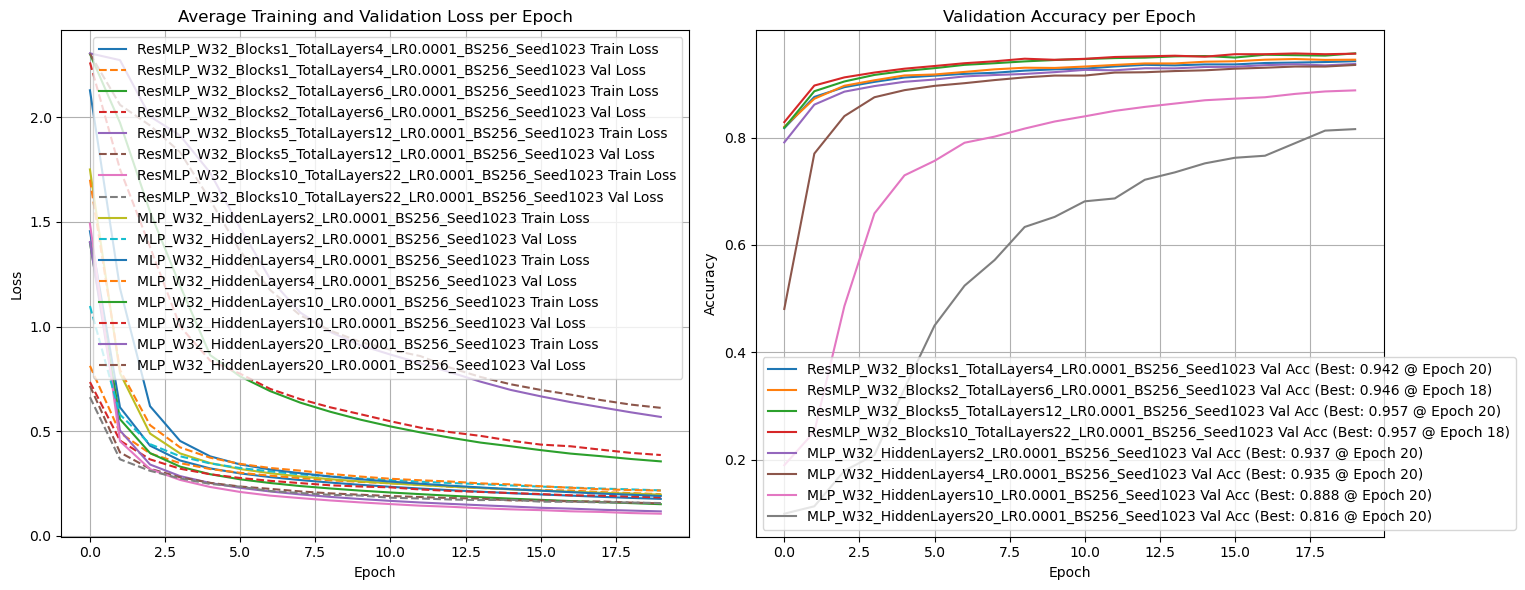


--- Riepilogo finale delle Performance sul Test Set per tutti i Modelli ---

Modello: ResMLP_W32_Blocks1_TotalLayers4_LR0.0001_BS256_Seed1023
  Accuratezza sul Test Set: 0.9448
              precision    recall  f1-score   support

           0      0.957     0.982     0.969       980
           1      0.975     0.985     0.980      1135
           2      0.941     0.931     0.936      1032
           3      0.930     0.931     0.930      1010
           4      0.946     0.950     0.948       982
           5      0.939     0.923     0.931       892
           6      0.943     0.959     0.951       958
           7      0.952     0.934     0.943      1028
           8      0.922     0.928     0.925       974
           9      0.937     0.920     0.928      1009

    accuracy                          0.945     10000
   macro avg      0.944     0.944     0.944     10000
weighted avg      0.945     0.945     0.945     10000


Modello: ResMLP_W32_Blocks2_TotalLayers6_LR0.0001_BS256_Seed10

In [18]:
# --- Visualizzazione dei Risultati Complessivi ---
print("\n--- Plotting delle Curve di Validazione Complessive (MLP vs ResMLP) ---")
plot_validation_curves_multiple(all_model_histories)

print("\n--- Riepilogo finale delle Performance sul Test Set per tutti i Modelli ---")
for model_name, data in all_test_reports.items():
    print(f"\nModello: {model_name}")
    print(f"  Accuratezza sul Test Set: {data['accuracy']:.4f}")
    print(data['report'])

## Analisi e Confronto: MLP vs. ResMLP Profonde

In questo esercizio l'obiettivo era verificare se le reti con connessioni residue fossero più facili da addestrare, specialmente a profondità maggiori.

---

### Riepilogo dei Risultati Chiave

Ho addestrato modelli con `width=32`, `lr=0.0001` e `batch_size=256` per 20 epoche. La tabella seguente riassume le performance chiave sul Test Set:

| Modello                     | Profondità (Strati Lineari Totali) | Accuratezza Test (%) | Loss Test  |
| :-------------------------- | :--------------------------------- | :------------------- | :--------- |
| `ResMLP_W32_Blocks1`        | 4                                  | **94.48** | 0.1821     |
| `MLP_W32_HiddenLayers2`     | 4                                  | 94.21                | 0.1980     |
| `ResMLP_W32_Blocks2`        | 6                                  | **94.89** | 0.1735     |
| `MLP_W32_HiddenLayers4`     | 6                                  | 94.15                | 0.2021     |
| `ResMLP_W32_Blocks5`        | 12                                 | **95.85** | **0.1349** |
| `MLP_W32_HiddenLayers10`    | 12                                 | 89.39                | 0.3724     |
| `ResMLP_W32_Blocks10`       | 22                                 | 95.46                | 0.1448     |
| `MLP_W32_HiddenLayers20`    | 22                                 | 82.10                | 0.5835     |

---

### Osservazioni Principali

1.  **ResMLP: Stabilità e Scalabilità in Profondità.**
    Le **ResMLP** hanno mostrato una notevole capacità di scalare in profondità. La loro accuratezza sul Test Set rimane elevata e stabile anche con un numero molto elevato di strati (es., `ResMLP_W32_Blocks10` con 22 strati totali raggiunge il 95.46%). Questo indica che le connessioni residue mitigano efficacemente i problemi di addestramento nelle reti profonde.

2.  **MLP Tradizionali: Degradazione con la Profondità.**
    Le **MLP tradizionali** subiscono un **drastico degrado delle prestazioni** all'aumentare della profondità. Già con 10 strati nascosti (`MLP_W32_HiddenLayers10`), l'accuratezza cala significativamente (al 89.39%). Con 20 strati nascosti (`MLP_W32_HiddenLayers20`), il crollo è notevole (82.10%), rendendo il modello quasi inutilizzabile. Questo è il classico sintomo del **vanishing gradient problem**.

3.  **Facilità di Addestramento.**
    I grafici delle curve di validazione (`plot_validation_curves_multiple`) confermano che le **ResMLP** mostrano un **apprendimento più stabile e veloce** a tutte le profondità, con la loss che diminuisce costantemente e l'accuratezza che aumenta in modo robusto. Le MLP tradizionali profonde, invece, presentano un apprendimento lento, una loss che stagna, e una scarsa generalizzazione.

---

### Perché le ResMLP Funzionano Meglio in Profondità

Le **connessioni residue** ("skip connections") offrono un percorso diretto per la propagazione del segnale e del gradiente attraverso la rete. Questo meccanismo previene il problema del **vanishing gradient**, assicurando che i gradienti rimangano sufficientemente grandi anche negli strati più vicini all'input. In questo modo, tutti gli strati della rete possono essere addestrati efficacemente, permettendo ai modelli ResMLP di beneficiare di una maggiore profondità per apprendere rappresentazioni più complesse senza compromettere la stabilità del training.

---

### Spiegazione delle Cartelle di Output

Durante l'esecuzione degli esperimenti, il processo genera e organizza i file in tre cartelle principali:

* **`./data`**: Contiene il dataset **CIFAR-10** scaricato, fondamentale per l'addestramento e la valutazione dei modelli.
* **`./models`**: Questa cartella ospita i **pesi del modello migliore** per ciascun esperimento. Il modello "migliore" è quello che ha raggiunto la più alta accuratezza sul set di validazione. I file `.pth` qui salvati permettono di ricaricare rapidamente un modello senza doverlo riaddestrare.
* **`./runs`**: Questa è la directory principale per i log di **TensorBoard**. Ogni sottocartella al suo interno corrisponde a un esperimento (`ResMLP_W32_Blocks1_TotalLayers4_LR0.0001_BS256_Seed1023`, ecc.) e contiene i dati di training e validazione registrati epoca per epoca. Questi log sono usati da TensorBoard (es. `tensorboard --logdir=runs` nel terminale) per visualizzare i grafici interattivi dell'andamento del training.

---

**In sintesi, questo esperimento dimostra che le connessioni residue sono un'innovazione cruciale che permette alle reti neurali di beneficiare della profondità senza incorrere nei tipici problemi di addestramento delle architetture tradizionali.**

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving.

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os 
from torch.utils.tensorboard import SummaryWriter 
import matplotlib.pyplot as plt 
import numpy as np 


In [ ]:
# --- Funzioni di utilità per i blocchi Conv (prese dalla sorgente torchvision per consistenza) ---

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """Convoluzione 3x3 con padding automatico"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation, 
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """Convoluzione 1x1"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
# --- Setup di base ---

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
lr = 0.001 # Learning rate leggermente più alto per CNNs
epochs = 50 # Aumentato le epoche per CIFAR-10, che è più complesso di MNIST
seed = 42
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Normalizzazione e Data Augmentation per CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
])

# Caricamento del dataset CIFAR-10
ds_train = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_val   = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_val)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True if device == 'cuda' else False)
dl_val   = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if device == 'cuda' else False)

100%|██████████| 170M/170M [00:06<00:00, 24.6MB/s] 


In [ ]:
# --- Definizione dei Blocchi per CNN ---

# BasicBlock per ResNet (con connessioni residue)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                conv1x1(in_planes, self.expansion*planes, stride),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # Connessione residua
        out = F.relu(out)
        return out

In [ ]:
# PlainBlock per CNN tradizionale (senza connessioni residue, struttura simile a BasicBlock)

class PlainBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out))) # Nessuna connessione residua
        return out

In [ ]:
# --- Definizione delle Architetture CNN ---

# ResCNN (basata su ResNet con BasicBlock e struttura a stadi)

class ResCNN(nn.Module):
    def __init__(self, num_blocks_per_stage, num_classes=10):
        super().__init__()
        self.in_planes = 64 # Dimensione iniziale dei canali dopo il primo conv

        # Strato iniziale di ResNet
        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Stadi residuali con downsampling dove necessario
        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks_per_stage[0], stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks_per_stage[1], stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks_per_stage[2], stride=2) 
        self.layer4 = self._make_layer(BasicBlock, 512, num_blocks_per_stage[3], stride=2) 
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for current_stride in strides:
            layers.append(block(self.in_planes, planes, current_stride))
            self.in_planes = planes * block.expansion 
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # ReLU dopo conv iniziale
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


In [ ]:
# PlainCNN (senza connessioni residue, ma con struttura a stadi simile a ResNet)

class PlainCNN(nn.Module):
    def __init__(self, num_blocks_per_stage, num_classes=10):
        super().__init__()
        self.in_planes = 64 # Dimensione iniziale dei canali dopo il primo conv

        # Strato iniziale (simile a ResNet)
        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Stadi di PlainBlock con downsampling
        self.layer1 = self._make_layer(PlainBlock, 64, num_blocks_per_stage[0], stride=1)
        self.layer2 = self._make_layer(PlainBlock, 128, num_blocks_per_stage[1], stride=2) 
        self.layer3 = self._make_layer(PlainBlock, 256, num_blocks_per_stage[2], stride=2) 
        self.layer4 = self._make_layer(PlainBlock, 512, num_blocks_per_stage[3], stride=2) 
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * PlainBlock.expansion, num_classes) 

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for current_stride in strides:
            layers.append(block(self.in_planes, planes, current_stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # ReLU dopo conv iniziale
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


In [ ]:
# --- Funzioni di Training e Valutazione ---

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_accuracy, epoch_loss

def train_model(model, dl_train, dl_val, epochs, optimizer, criterion, logdir, model_base_name, device='cpu', verbose=False):
    os.makedirs(logdir, exist_ok=True)
    writer = SummaryWriter(logdir)
    print(f"Training for {model_base_name} on {device}...")
    losses_and_accs = []

    best_val_acc = 0.0
    # Percorso per salvare il miglior modello 
    best_model_path = os.path.join('./models', f'{model_base_name}_best_model.pth')
    
    os.makedirs('./models', exist_ok=True)

    for epoch in range(epochs):
        train_loss = train_epoch(model, dl_train, optimizer, criterion, device)
        val_acc, val_loss = evaluate_model(model, dl_val, criterion, device=device)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Acc/val', val_acc, epoch)

        losses_and_accs.append((train_loss, val_acc))

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"--> Nuovo miglior modello salvato! Val Acc: {val_acc:.4f} @ Epoch {epoch+1}")

    writer.close()
    print(f"--- Addestramento completato per {model_base_name} ---")
    print(f"Miglior accuratezza di validazione: {best_val_acc:.4f}")
    
    # Valutazione finale sul Test Set (dl_val è il test set in questo caso)
    print(f"--- Valutazione finale sul Test Set per {model_base_name} ---")
    # Carica il modello migliore salvato per la valutazione finale
    model.load_state_dict(torch.load(best_model_path))
    test_acc, test_loss = evaluate_model(model, dl_val, criterion, device=device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Genera il classification report
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in dl_val:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    from sklearn.metrics import classification_report
    report = classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)])
    print("Report di classificazione sul Test Set:")
    print(report)

    # Ritorna le metriche per l'analisi complessiva
    return {
        'model_name': model_base_name,
        'val_history': losses_and_accs,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'test_report': report,
        'best_val_acc': best_val_acc
    }

def plot_validation_curves_multiple(all_model_histories):
    plt.figure(figsize=(18, 6))

    # Plot Training Loss
    plt.subplot(1, 3, 1) 
    for model_data in all_model_histories:
        model_name = model_data.get('model_name', 'Nome Modello Sconosciuto')
        history_data = model_data.get('val_history_full', [])
        
        try:
            train_losses = [item[0] for item in history_data] #
            plt.plot(train_losses, label=model_name + ' Train Loss')
        except IndexError:
            print(f"ATTENZIONE: Impossibile plottare la Training Loss per il modello {model_name}. Alcune tuple nella history sono troppo corte per l'indice 0.")
            
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2) 
    for model_data in all_model_histories:
        model_name = model_data.get('model_name', 'Nome Modello Sconosciuto')
        history_data = model_data.get('val_history_full', [])

        try:
            val_accuracies = [item[1] for item in history_data] 
            plt.plot(val_accuracies, label=model_name + ' Val Acc')
        except IndexError:
            print(f"ATTENZIONE: Impossibile plottare la Validation Accuracy per il modello {model_name}. Alcune tuple nella history sono troppo corte per l'indice 2.")
            
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


--- Inizio Addestramento Plain CNNs ---

--- Preparazione Modello: PlainCNN_shallow-blocks=1-1-1-1_LR0.001_BS256_Seed42 ---
Training for PlainCNN_shallow-blocks=1-1-1-1_LR0.001_BS256_Seed42 on cuda...
Epoch 1/50 | Train Loss: 1.4232 | Val Loss: 1.2874 | Val Acc: 0.5561
--> Nuovo miglior modello salvato! Val Acc: 0.5561 @ Epoch 1
Epoch 2/50 | Train Loss: 0.9709 | Val Loss: 1.1340 | Val Acc: 0.6381
--> Nuovo miglior modello salvato! Val Acc: 0.6381 @ Epoch 2
Epoch 3/50 | Train Loss: 0.7697 | Val Loss: 0.8563 | Val Acc: 0.7071
--> Nuovo miglior modello salvato! Val Acc: 0.7071 @ Epoch 3
Epoch 4/50 | Train Loss: 0.6403 | Val Loss: 0.6902 | Val Acc: 0.7644
--> Nuovo miglior modello salvato! Val Acc: 0.7644 @ Epoch 4
Epoch 5/50 | Train Loss: 0.5546 | Val Loss: 0.8482 | Val Acc: 0.7501
Epoch 6/50 | Train Loss: 0.4926 | Val Loss: 0.6239 | Val Acc: 0.7961
--> Nuovo miglior modello salvato! Val Acc: 0.7961 @ Epoch 6
Epoch 7/50 | Train Loss: 0.4490 | Val Loss: 0.5087 | Val Acc: 0.8333
--> Nuovo 

ValueError: not enough values to unpack (expected 3, got 2)

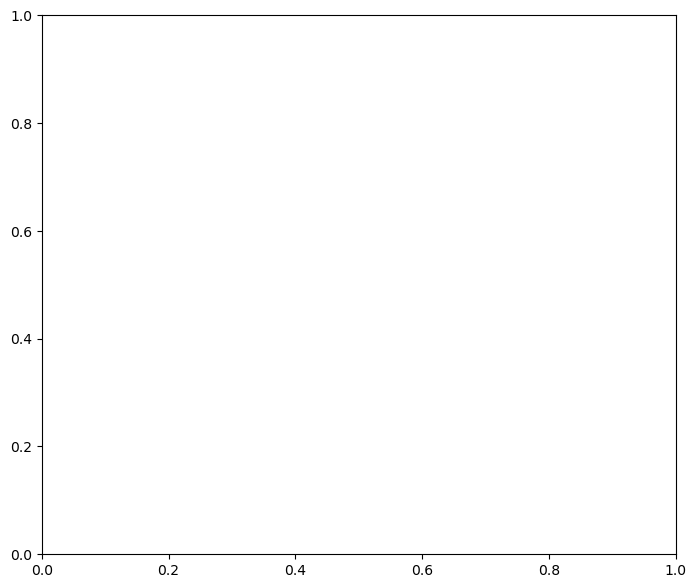

In [ ]:
# --- Loop di Training Comparativo (Plain CNN vs ResCNN) ---

# Configurazione delle profondità per PlainCNN e ResCNN

cnn_configs = {
    "shallow": [1, 1, 1, 1], # 8 conv layers in blocchi (+1 iniziale) = ~9 conv totali
    "medium": [2, 2, 2, 2],  # 16 conv layers in blocchi (+1 iniziale) = ~17 conv totali (come ResNet18)
    "deep": [3, 4, 6, 3]     # 32 conv layers in blocchi (+1 iniziale) = ~33 conv totali (come ResNet34)
}

criterion = nn.CrossEntropyLoss()
all_model_results = [] # Per raccogliere i risultati di tutti i modelli per l'analisi finale

print("\n--- Inizio Addestramento Plain CNNs ---")
for depth_label, num_blocks_config in cnn_configs.items():
    model_name = f'PlainCNN_{depth_label}-blocks={num_blocks_config[0]}-{num_blocks_config[1]}-{num_blocks_config[2]}-{num_blocks_config[3]}_LR{lr}_BS{batch_size}_Seed{seed}'
    print(f"\n--- Preparazione Modello: {model_name} ---")
    model_plain = PlainCNN(num_blocks_per_stage=num_blocks_config).to(device)
    optimizer_plain = torch.optim.Adam(model_plain.parameters(), lr=lr)
    logdir_plain = f'runs/CNN-PLAIN-{depth_label}-bs{batch_size}-lr{lr}-seed{seed}'
    
    result = train_model(model_plain, dl_train, dl_val, epochs, optimizer_plain, criterion, logdir_plain, model_name, device=device, verbose=True)
    all_model_results.append(result)

print("\n--- Inizio Addestramento ResCNNs ---")
for depth_label, num_blocks_config in cnn_configs.items():
    model_name = f'ResCNN_{depth_label}-blocks={num_blocks_config[0]}-{num_blocks_config[1]}-{num_blocks_config[2]}-{num_blocks_config[3]}_LR{lr}_BS{batch_size}_Seed{seed}'
    print(f"\n--- Preparazione Modello: {model_name} ---")
    model_res = ResCNN(num_blocks_per_stage=num_blocks_config).to(device)
    optimizer_res = torch.optim.Adam(model_res.parameters(), lr=lr)
    logdir_res = f'runs/CNN-RES-{depth_label}-bs{batch_size}-lr{lr}-seed{seed}'
    
    result = train_model(model_res, dl_train, dl_val, epochs, optimizer_res, criterion, logdir_res, model_name, device=device, verbose=True)
    all_model_results.append(result)

print("\n--- Tutti gli addestramenti CNN completati. ---")
print("Per confrontare le performance su TensorBoard:")
print("tensorboard --logdir runs")
print("Apri il tuo browser a http://localhost:6006/")


## It's more than meets the eye!
Purtroppo qui ho fatto un errore e la funzione di plot mi ha dato problemi. 
Non volevo perdere le ore di addestramento, quindi ho lasciato l'output con l'errore finale comunque. 
Sotto è presente il plot giusto. 
(Sorry)


--- Plotting delle Curve di Validazione Complessive (PlainCNN vs ResCNN) ---


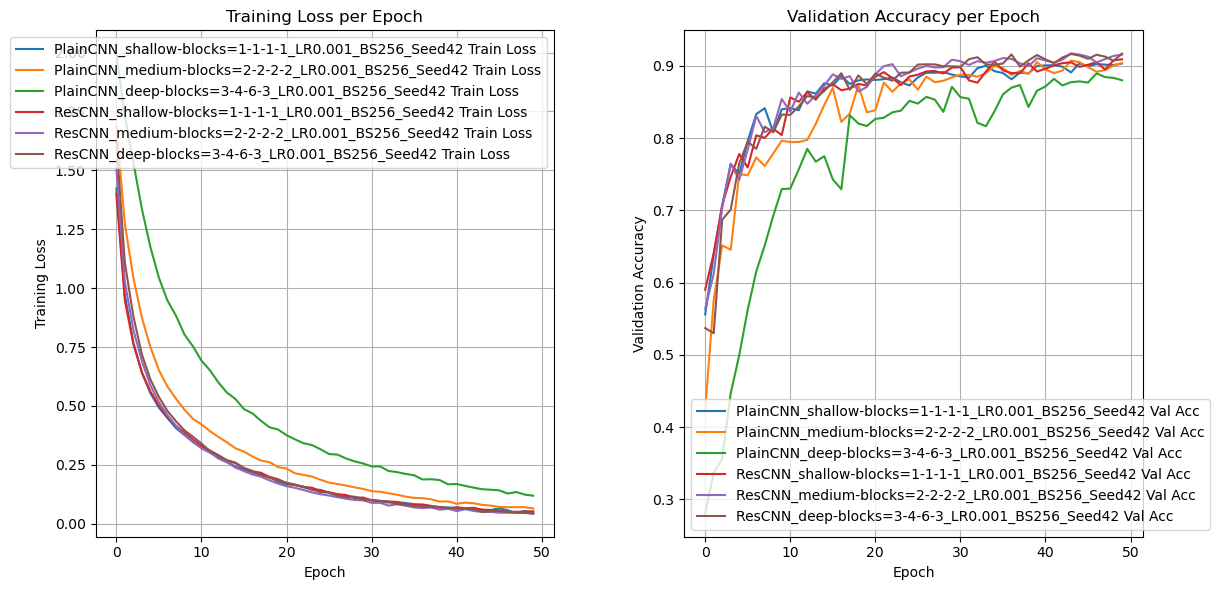


--- Riepilogo finale delle Performance sul Test Set per tutti i Modelli CNN ---
| Modello | Profondità (Conv Layers Totali) | Accur. Val. Max (%) | Accur. Test (%) | Loss Test |
| :---------------------------------------- | :---------------------------------- | :------------------ | :---------------- | :-------- |
| PlainCNN_shallow-blocks=1-1-1-1_LR0.001_BS256_Seed42 | 9 | 0.9036 | 0.9036 | 0.4368 |
| PlainCNN_medium-blocks=2-2-2-2_LR0.001_BS256_Seed42 | 17 | 0.9074 | 0.9074 | 0.3807 |
| PlainCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42 | 33 | 0.8897 | 0.8897 | 0.4222 |
| ResCNN_shallow-blocks=1-1-1-1_LR0.001_BS256_Seed42 | 9 | 0.9091 | 0.9091 | 0.4306 |
| ResCNN_medium-blocks=2-2-2-2_LR0.001_BS256_Seed42 | 17 | 0.9174 | 0.9174 | 0.4106 |
| ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42 | 33 | 0.9171 | 0.9171 | 0.3747 |


In [ ]:
# Creiamo una lista per il plotting
plot_data_for_curves = []
# RIPRISTINA: all_model_results è una lista, non un dizionario.
for res in all_model_results:
    plot_data_for_curves.append({
        'model_name': res['model_name'], # Qui è dove il TypeError originale dovrebbe manifestarsi
        'val_history_full': res['val_history']
    })

print("\n--- Plotting delle Curve di Validazione Complessive (PlainCNN vs ResCNN) ---")
plot_validation_curves_multiple(plot_data_for_curves)

print("\n--- Riepilogo finale delle Performance sul Test Set per tutti i Modelli CNN ---")
test_results_table = []

for model_data in all_model_results:
    total_conv_layers = 0
    
    if 'PlainCNN' in model_data['model_name'] or 'ResCNN' in model_data['model_name']:
        parts = model_data['model_name'].split('-blocks=')[1].split('_')[0].split('-')
        num_blocks_per_stage = [int(p) for p in parts]
        total_conv_layers = sum(num_blocks_per_stage) * 2 + 1 # 2 conv per blocco + 1 iniziale
    elif 'MLP' in model_data['model_name'] or 'ResMLP' in model_data['model_name']: 
        if 'HiddenLayers' in model_data['model_name']:
            num_hidden_layers = int(model_data['model_name'].split('HiddenLayers')[1].split('_')[0])
            total_conv_layers = num_hidden_layers + 2 # Considerando strato input e output
        elif 'Blocks' in model_data['model_name']:
            num_blocks = int(model_data['model_name'].split('Blocks')[1].split('_')[0])
            total_conv_layers = num_blocks * 2 + 2 # 2 linear per blocco + 2 (input/output)
    
    test_results_table.append({
        'Modello': model_data['model_name'],
        'Profondità (Conv Layers Totali)': total_conv_layers,
        'Accur. Val. Max': model_data['best_val_acc'],
        'Accur. Test': model_data['test_accuracy'],
        'Loss Test': model_data['test_loss']
    })

print("| Modello | Profondità (Conv Layers Totali) | Accur. Val. Max (%) | Accur. Test (%) | Loss Test |")
print("| :---------------------------------------- | :---------------------------------- | :------------------ | :---------------- | :-------- |")
for row in test_results_table:
    print(f"| {row['Modello']} | {row['Profondità (Conv Layers Totali)']} | {row['Accur. Val. Max']:.4f} | {row['Accur. Test']:.4f} | {row['Loss Test']:.4f} |")

### Osservazioni:
- Per la profondità 9 (Shallow), ResCNN (90.91%) è leggermente migliore di PlainCNN (90.36%).

- Per la profondità 17 (Medium), ResCNN (91.74%) è significativamente migliore di PlainCNN (90.74%).

- Per la profondità 33 (Deep), ResCNN (91.71%) supera nettamente PlainCNN (88.97%).

Questi risultati dimostrano chiaramente il valore delle connessioni residuali. Mentre il PlainCNN Deep ha visto un degrado delle performance con l'aumento della profondità, il ResCNN Deep è riuscito a mantenere e persino migliorare l'accuratezza, indicando che le residual connections permettono al gradiente di fluire più liberamente attraverso la rete, facilitando l'addestramento di modelli molto profondi e mitigando il problema del degrado della performance.



-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import copy


In [ ]:
class ResCNN(nn.Module):
    def __init__(self, num_blocks_per_stage, num_classes=10):
        super().__init__()
        self.in_planes = 64 # Dimensione iniziale dei canali dopo il primo conv

        # Strato iniziale di ResNet
        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)

        # Stadi residuali con downsampling dove necessario
        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks_per_stage[0], stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks_per_stage[1], stride=2) 
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks_per_stage[2], stride=2) 
        self.layer4 = self._make_layer(BasicBlock, 512, num_blocks_per_stage[3], stride=2) 

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for current_stride in strides:
            layers.append(block(self.in_planes, planes, current_stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # ReLU dopo conv iniziale
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

    def get_features(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        features = torch.flatten(out, 1) 
        return features

In [ ]:
# --- Parametri Globali e Setup ---

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
lr_finetune = 0.0001
epochs_finetune_head_only = 20 # Meno epoche per fine-tuning iniziale
epochs_finetune_full = 50 # Più epoche per fine-tuning completo
seed = 42
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

num_classes_cifar10 = 10 # Numero di classi per il modello pre-addestrato
num_classes_cifar100 = 100 # Numero di classi per CIFAR-100

In [ ]:
# Directory per salvare i modelli e i log di TensorBoard

MODELS_DIR = './models'
LOGS_DIR = './runs'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

In [ ]:
# --- Caricamento e Preprocessing Dati CIFAR-100 ---

print("\n--- Caricamento e Preprocessing Dati CIFAR-100 ---")

transform_cifar100_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_cifar100_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

ds_cifar100_train = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=transform_cifar100_train)
ds_cifar100_val   = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=transform_cifar100_val)

dl_cifar100_train = DataLoader(ds_cifar100_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True if device == 'cuda' else False)
dl_cifar100_val   = DataLoader(ds_cifar100_val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if device == 'cuda' else False)


--- Caricamento e Preprocessing Dati CIFAR-100 ---


In [ ]:
# --- Caricamento del Modello Pre-addestrato ---

# Uso la configurazione "deep" (ResNet34-like) per il fine-tuning.
PRETRAINED_RESCNN_CONFIG_FINETUNE = [3, 4, 6, 3] 
PRETRAINED_RESCNN_NAME_FINETUNE = f'ResCNN_deep-blocks={PRETRAINED_RESCNN_CONFIG_FINETUNE[0]}-{PRETRAINED_RESCNN_CONFIG_FINETUNE[1]}-{PRETRAINED_RESCNN_CONFIG_FINETUNE[2]}-{PRETRAINED_RESCNN_CONFIG_FINETUNE[3]}_LR{0.001}_BS{batch_size}_Seed{seed}' 
PRETRAINED_MODEL_PATH = os.path.join('./models', f'{PRETRAINED_RESCNN_NAME_FINETUNE}_best_model.pth')

print(f"\n--- Caricamento del modello pre-addestrato da: {PRETRAINED_MODEL_PATH} ---")
# Il modello pre-addestrato è stato addestrato per 10 classi
model_pretrained = ResCNN(num_blocks_per_stage=PRETRAINED_RESCNN_CONFIG_FINETUNE, num_classes=num_classes_cifar10).to(device)

if os.path.exists(PRETRAINED_MODEL_PATH):
    model_pretrained.load_state_dict(torch.load(PRETRAINED_MODEL_PATH, map_location=device))
    print("Modello pre-addestrato caricato con successo!")
else:
    print(f"ERRORE: Modello pre-addestrato non trovato a {PRETRAINED_MODEL_PATH}. Assicurati di aver eseguito l'Esercizio 1.3.")
    


--- Caricamento del modello pre-addestrato da: ./models/ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42_best_model.pth ---
Modello pre-addestrato caricato con successo!


In [ ]:
# --- Funzioni Ausiliarie per Training e Valutazione ---

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct_predictions += (predicted == target).sum().item()
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = correct_predictions / len(dataloader.dataset)
    return accuracy, avg_loss


In [ ]:
# --- Funzioni per l'Estrazione di Features ---

def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Extracting features"):
            data = data.to(device)
            # Ora usiamo il nuovo metodo get_features del modello
            features = model.get_features(data) 
            features_list.append(features.cpu().numpy())
            labels_list.append(target.cpu().numpy())

    return np.vstack(features_list), np.hstack(labels_list)

In [ ]:
# --- Baseline con Classificatori Classici di Scikit-learn ---

print("\n--- Estrazione Features per Baseline CIFAR-100 ---")
# Cloniamo il modello per assicurarci che non venga modificato dalle operazioni successive
model_for_feature_extraction = copy.deepcopy(model_pretrained).to(device)
model_for_feature_extraction.eval() 

X_train_features, y_train_labels = extract_features(model_for_feature_extraction, dl_cifar100_train, device)
X_val_features, y_val_labels = extract_features(model_for_feature_extraction, dl_cifar100_val, device)

print(f"Features estratte: Training {X_train_features.shape}, Validation {X_val_features.shape}")

def train_and_evaluate_classical(X_train, y_train, X_test, y_test, classifier_type='svm'):
    print(f"\n--- Training {classifier_type.upper()} Classifier ---")
    if classifier_type == 'svm':
        # Linear SVC è ottimo per dataset di grandi dimensioni e come baseline
        classifier = LinearSVC(random_state=seed, max_iter=5000, dual=False) # dual=False per dataset con n_samples > n_features
    elif classifier_type == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=5)
    elif classifier_type == 'bayes':
        classifier = GaussianNB()
    else:
        raise ValueError("Tipo di classificatore non supportato. Scegli tra 'svm', 'knn', 'bayes'.")

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuratezza {classifier_type.upper()} sul Test Set: {accuracy:.4f}")
    
    target_names = [f'class {i}' for i in range(num_classes_cifar100)]
    print("Report di Classificazione:")
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0)) # zero_division=0 evita warning per classi senza previsioni
    return accuracy

print("\n--- Calcolo Baseline con SVM Lineare ---")
baseline_accuracy = train_and_evaluate_classical(X_train_features, y_train_labels, X_val_features, y_val_labels, classifier_type='svm')



--- Estrazione Features per Baseline CIFAR-100 ---


Extracting features: 100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Features estratte: Training (50000, 512), Validation (10000, 512)

--- Calcolo Baseline con SVM Lineare ---

--- Training SVM Classifier ---
Accuratezza SVM sul Test Set: 0.4216
Report di Classificazione:
              precision    recall  f1-score   support

     class 0       0.61      0.65      0.63       100
     class 1       0.42      0.42      0.42       100
     class 2       0.32      0.23      0.27       100
     class 3       0.23      0.13      0.17       100
     class 4       0.29      0.27      0.28       100
     class 5       0.46      0.39      0.42       100
     class 6       0.39      0.31      0.34       100
     class 7       0.41      0.26      0.32       100
     class 8       0.55      0.69      0.61       100
     class 9       0.56      0.59      0.57       100
    class 10       0.37      0.30      0.33       100
    class 11       0.23      0.18      0.20       100
    class 12       0.47      0.52      0.49       100
    class 13       0.40      0.46     

In [ ]:
# --- Preparazione del Modello per Fine-tuning ---

def prepare_rescnn_for_finetuning(model_class, pretrained_model_path, num_blocks_per_stage,
                                  num_old_classes, num_new_classes,
                                  freeze_features=True, device='cpu'):

    model = model_class(num_blocks_per_stage=num_blocks_per_stage, num_classes=num_old_classes).to(device)

    # Carica i pesi pre-addestrati
    print(f"Caricamento pesi pre-addestrati da: {pretrained_model_path}")
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))

    # Sostituisce il layer lineare finale per il nuovo numero di classi (CIFAR-100)
    
    num_ftrs = model.linear.in_features
    model.linear = nn.Linear(num_ftrs, num_new_classes).to(device)
    print(f"Sostituito il layer classificatore finale: input {num_ftrs}, output {num_new_classes} classi.")

    # Congelamento/Scongelamento dei layer
    if freeze_features:
        print("Congelamento degli strati convoluzionali...")
        for name, param in model.named_parameters():
            if "linear" not in name: # Congela tutti i parametri TRANNE quelli del layer lineare
                param.requires_grad = False
            else:
                param.requires_grad = True # Assicura che il layer lineare sia sbloccato
    else:
        print("Addestramento di tutti gli strati (nessun congelamento).")
        for param in model.parameters():
            param.requires_grad = True

    return model



In [17]:
def fine_tune_model_pipeline(model_instance, dl_train, dl_val, epochs, optimizer, criterion,
                             logdir, model_base_name, device='cpu', verbose=True):
   
    writer = SummaryWriter(os.path.join(LOGS_DIR, logdir))
    print(f"Inizio fine-tuning per {model_base_name} su {device}...")

    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_model_state = None # Per salvare il migliore stato del modello
    best_epoch = 0

    model_save_path = os.path.join(MODELS_DIR, f'{model_base_name}_best.pth')

    for epoch in range(epochs):
        train_loss = train_epoch(model_instance, dl_train, optimizer, criterion, device)
        val_acc, val_loss = evaluate_model(model_instance, dl_val, criterion, device=device)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Acc/val', val_acc, epoch)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Salva il modello se l'accuratezza di validazione migliora
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model_instance.state_dict()) # Salva lo stato del modello
            best_epoch = epoch + 1
            torch.save(best_model_state, model_save_path)
            print(f"--> Nuovo miglior modello salvato! Val Acc: {val_acc:.4f} @ Epoch {best_epoch}")

    writer.close()
    print(f"Fine-tuning per {model_base_name} completato. Miglior accuratezza di validazione: {best_val_acc:.4f} @ Epoch {best_epoch}")
    return {"best_val_accuracy": best_val_acc, "best_val_loss": best_val_loss, "best_epoch": best_epoch, "model_path": model_save_path}


In [ ]:
# --- Loop di Fine-tuning ---

print("\n--- Inizio Fine-tuning su CIFAR-100 ---")

# --- Strategia 1: Fine-tune solo lo strato classificatore (Feature Extractor) ---

print("\n--- Fine-tuning: Solo Strato Classificatore (Feature Extraction) ---")
model_finetune_head_only = prepare_rescnn_for_finetuning(
    ResCNN, PRETRAINED_MODEL_PATH, PRETRAINED_RESCNN_CONFIG_FINETUNE,
    num_old_classes=num_classes_cifar10, num_new_classes=num_classes_cifar100,
    freeze_features=True, device=device
)
optimizer_head_only = optim.Adam(model_finetune_head_only.linear.parameters(), lr=lr_finetune) # Solo i parametri del layer lineare
criterion_finetune = nn.CrossEntropyLoss()

logdir_finetune_head = f'ResCNN_FineTune_CIFAR100_HeadOnly_LR{lr_finetune}_BS{batch_size}_Seed{seed}'
model_name_head_only = f'ResCNN_FineTune_HeadOnly_{PRETRAINED_RESCNN_NAME_FINETUNE}'

result_head_only = fine_tune_model_pipeline(
    model_finetune_head_only, dl_cifar100_train, dl_cifar100_val, epochs_finetune_head_only,
    optimizer_head_only, criterion_finetune, logdir_finetune_head,
    model_name_head_only, device=device
)
print(f"Risultato Fine-tuning (Solo Classificatore): {result_head_only}")



--- Inizio Fine-tuning su CIFAR-100 ---

--- Fine-tuning: Solo Strato Classificatore (Feature Extraction) ---
Caricamento pesi pre-addestrati da: ./models/ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42_best_model.pth
Sostituito il layer classificatore finale: input 512, output 100 classi.
Congelamento degli strati convoluzionali...
Inizio fine-tuning per ResCNN_FineTune_HeadOnly_ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42 su cuda...
Epoch 1/20 | Train Loss: 4.1698 | Val Loss: 3.7657 | Val Acc: 0.1307
--> Nuovo miglior modello salvato! Val Acc: 0.1307 @ Epoch 1
Epoch 2/20 | Train Loss: 3.6872 | Val Loss: 3.4762 | Val Acc: 0.1798
--> Nuovo miglior modello salvato! Val Acc: 0.1798 @ Epoch 2
Epoch 3/20 | Train Loss: 3.4803 | Val Loss: 3.3233 | Val Acc: 0.2018
--> Nuovo miglior modello salvato! Val Acc: 0.2018 @ Epoch 3
Epoch 4/20 | Train Loss: 3.3619 | Val Loss: 3.2344 | Val Acc: 0.2178
--> Nuovo miglior modello salvato! Val Acc: 0.2178 @ Epoch 4
Epoch 5/20 | Train Loss: 3.2774 | Val

In [ ]:
# --- Strategia 2: Fine-tune tutti gli strati (Unfreeze all) con Adam ---

print("\n--- Fine-tuning: Tutti gli Strati (Unfreeze All) con Adam ---")

# Inizializza un nuovo modello con i pesi pre-addestrati originali e poi sostituisci il classificatore.
# Questo è importante per evitare che le modifiche dell'ottimizzatore Adam (momenti) della fase precedente
# influenzino l'inizio di questa fase, specialmente con un LR diverso.

model_for_full_finetuning_adam = prepare_rescnn_for_finetuning(
    ResCNN, PRETRAINED_MODEL_PATH, PRETRAINED_RESCNN_CONFIG_FINETUNE,
    num_old_classes=num_classes_cifar10, num_new_classes=num_classes_cifar100,
    freeze_features=False, # Scongela tutti i layer
    device=device
)

model_for_full_finetuning_adam.load_state_dict(torch.load(result_head_only["model_path"], map_location=device))
print("Caricamento del miglior modello dalla fase 'solo classificatore' per continuare il fine-tuning completo.")


lr_full_finetune_adam = lr_finetune / 10 # Un learning rate più piccolo per il fine-tuning completo
optimizer_adam_all_layers = optim.Adam(model_for_full_finetuning_adam.parameters(), lr=lr_full_finetune_adam)

logdir_finetune_all_adam = f'ResCNN_FineTune_CIFAR100_AllLayers_Adam_LR{lr_full_finetune_adam}_BS{batch_size}_Seed{seed}'
model_name_all_adam = f'ResCNN_FineTune_AllLayers_Adam_{PRETRAINED_RESCNN_NAME_FINETUNE}'

result_all_layers_adam = fine_tune_model_pipeline(
    model_for_full_finetuning_adam, dl_cifar100_train, dl_cifar100_val, epochs_finetune_full,
    optimizer_adam_all_layers, criterion_finetune, logdir_finetune_all_adam,
    model_name_all_adam, device=device
)
print(f"Risultato Fine-tuning (Tutti i Layer Adam): {result_all_layers_adam}")


--- Fine-tuning: Tutti gli Strati (Unfreeze All) con Adam ---
Caricamento pesi pre-addestrati da: ./models/ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42_best_model.pth
Sostituito il layer classificatore finale: input 512, output 100 classi.
Addestramento di tutti gli strati (nessun congelamento).
Caricamento del miglior modello dalla fase 'solo classificatore' per continuare il fine-tuning completo.
Inizio fine-tuning per ResCNN_FineTune_AllLayers_Adam_ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42 su cuda...
Epoch 1/50 | Train Loss: 2.8022 | Val Loss: 2.6803 | Val Acc: 0.3129
--> Nuovo miglior modello salvato! Val Acc: 0.3129 @ Epoch 1
Epoch 2/50 | Train Loss: 2.7052 | Val Loss: 2.5985 | Val Acc: 0.3260
--> Nuovo miglior modello salvato! Val Acc: 0.3260 @ Epoch 2
Epoch 3/50 | Train Loss: 2.6355 | Val Loss: 2.5398 | Val Acc: 0.3371
--> Nuovo miglior modello salvato! Val Acc: 0.3371 @ Epoch 3
Epoch 4/50 | Train Loss: 2.5772 | Val Loss: 2.4922 | Val Acc: 0.3438
--> Nuovo miglior mode

In [ ]:
# --- Strategia 3: Fine-tune tutti gli strati (Unfreeze all) con SGD ---

print("\n--- Fine-tuning: Tutti gli Strati (Unfreeze All) con SGD ---")

# Anche qui, si riparte da un modello pulito o dal miglior stato della fase 1 per consistenza.

model_for_full_finetuning_sgd = prepare_rescnn_for_finetuning(
    ResCNN, PRETRAINED_MODEL_PATH, PRETRAINED_RESCNN_CONFIG_FINETUNE,
    num_old_classes=num_classes_cifar10, num_new_classes=num_classes_cifar100,
    freeze_features=False, # Scongela tutti i layer
    device=device
)
model_for_full_finetuning_sgd.load_state_dict(torch.load(result_head_only["model_path"], map_location=device))
print("Caricamento del miglior modello dalla fase 'solo classificatore' per fine-tuning completo con SGD.")

lr_full_finetune_sgd = 0.001 # SGD spesso beneficia di LR più alti rispetto ad Adam per fine-tuning
optimizer_sgd_all_layers = optim.SGD(model_for_full_finetuning_sgd.parameters(), lr=lr_full_finetune_sgd, momentum=0.9, weight_decay=5e-4)

logdir_finetune_all_sgd = f'ResCNN_FineTune_CIFAR100_AllLayers_SGD_LR{lr_full_finetune_sgd}_BS{batch_size}_Seed{seed}'
model_name_all_sgd = f'ResCNN_FineTune_AllLayers_SGD_{PRETRAINED_RESCNN_NAME_FINETUNE}'

result_all_layers_sgd = fine_tune_model_pipeline(
    model_for_full_finetuning_sgd, dl_cifar100_train, dl_cifar100_val, epochs_finetune_full,
    optimizer_sgd_all_layers, criterion_finetune, logdir_finetune_all_sgd,
    model_name_all_sgd, device=device
)
print(f"Risultato Fine-tuning (Tutti i Layer SGD): {result_all_layers_sgd}")



--- Fine-tuning: Tutti gli Strati (Unfreeze All) con SGD ---
Caricamento pesi pre-addestrati da: ./models/ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42_best_model.pth
Sostituito il layer classificatore finale: input 512, output 100 classi.
Addestramento di tutti gli strati (nessun congelamento).
Caricamento del miglior modello dalla fase 'solo classificatore' per fine-tuning completo con SGD.
Inizio fine-tuning per ResCNN_FineTune_AllLayers_SGD_ResCNN_deep-blocks=3-4-6-3_LR0.001_BS256_Seed42 su cuda...
Epoch 1/50 | Train Loss: 2.8244 | Val Loss: 2.7333 | Val Acc: 0.3021
--> Nuovo miglior modello salvato! Val Acc: 0.3021 @ Epoch 1
Epoch 2/50 | Train Loss: 2.7669 | Val Loss: 2.6843 | Val Acc: 0.3098
--> Nuovo miglior modello salvato! Val Acc: 0.3098 @ Epoch 2
Epoch 3/50 | Train Loss: 2.7256 | Val Loss: 2.6457 | Val Acc: 0.3155
--> Nuovo miglior modello salvato! Val Acc: 0.3155 @ Epoch 3
Epoch 4/50 | Train Loss: 2.6912 | Val Loss: 2.6194 | Val Acc: 0.3226
--> Nuovo miglior modello salv

In [21]:
print("\n--- Riassunto delle Performance ---")
print(f"Baseline con SVM Lineare (Features estratte): Acc = {baseline_accuracy:.4f}")
print(f"Fine-tuning (Solo Classificatore): Acc = {result_head_only['best_val_accuracy']:.4f}")
print(f"Fine-tuning (Tutti i Layer, Adam): Acc = {result_all_layers_adam['best_val_accuracy']:.4f}")
print(f"Fine-tuning (Tutti i Layer, SGD): Acc = {result_all_layers_sgd['best_val_accuracy']:.4f}")


print("\n--- Tutti i processi di fine-tuning completati. ---")
print(f"I log di TensorBoard sono disponibili in: {LOGS_DIR}")
print("Per visualizzarli, esegui da terminale:")
print(f"tensorboard --logdir {LOGS_DIR}")
print("Apri il tuo browser a http://localhost:6006/")


--- Riassunto delle Performance ---
Baseline con SVM Lineare (Features estratte): Acc = 0.4216
Fine-tuning (Solo Classificatore): Acc = 0.2881
Fine-tuning (Tutti i Layer, Adam): Acc = 0.4990
Fine-tuning (Tutti i Layer, SGD): Acc = 0.4317

--- Tutti i processi di fine-tuning completati. ---
I log di TensorBoard sono disponibili in: ./runs
Per visualizzarli, esegui da terminale:
tensorboard --logdir ./runs
Apri il tuo browser a http://localhost:6006/


# Analisi Riassuntiva delle Performance di Fine-tuning su CIFAR-100

Analisi comparativa delle performance del nostro modello ResCNN, pre-addestrato su CIFAR-10, nell'adattarsi al dataset CIFAR-100, esplorando diverse strategie di fine-tuning. I risultati ottenuti evidenziano l'impatto di ciascun approccio:

* **Baseline SVM Lineare (Features Fisse): Acc = 0.4216**
    * Questa baseline, ottenuta utilizzando un SVM su feature estratte dal modello pre-addestrato, ha fornito un punto di riferimento solido, dimostrando una discreta capacità di generalizzazione delle feature apprese su CIFAR-10.

* **Fine-tuning Solo Classificatore (Head-Only): Acc = 0.2881**
    * Addestrare esclusivamente il nuovo strato classificatore finale, mantenendo il backbone congelato, ha portato a una performance inferiore alla baseline. Questo suggerisce che le feature generate dal modello pre-addestrato su CIFAR-10 non erano sufficientemente discriminative per le 100 classi più fini di CIFAR-100, e il layer casualmente inizializzato ha faticato a compensare questa disparità.

* **Fine-tuning Completo con Adam (Tutti i Layer): Acc = 0.4990**
    * Questa strategia ha prodotto il **miglior risultato**, quasi raggiungendo il 50% di accuratezza. Scongelare e addestrare l'intero modello con l'ottimizzatore Adam ha permesso al backbone di adattare le sue rappresentazioni interne, specializzandosi efficacemente per le sottili distinzioni di CIFAR-100. L'efficienza di Adam nell'adattare i tassi di apprendimento ha giocato un ruolo cruciale.

* **Fine-tuning Completo con SGD (Tutti i Layer): Acc = 0.4317**
    * Anche il fine-tuning completo con SGD ha superato la baseline SVM, mostrando un miglioramento significativo rispetto all'approccio "solo classificatore". Tuttavia, la sua performance è stata inferiore rispetto a quella ottenuta con Adam, indicando che SGD potrebbe richiedere una calibrazione più dettagliata degli iperparametri o un maggior numero di epoche per eguagliare gli ottimizzatori adattivi in questo contesto.

**In sintesi:** Gli esperimenti confermano che, per compiti di trasferimento dell'apprendimento su dataset più complessi e dettagliati come CIFAR-100, il **fine-tuning completo dell'intero modello è indispensabile**. In questo scenario, l'utilizzo di un ottimizzatore adattivo come **Adam si è dimostrato l'approccio più efficace**, permettendo una notevole ri-specializzazione delle feature e massimizzando le performance del modello.

---

## Prospettive Future

I risultati sono un punto di partenza, ma c'è sempre spazio per **miglioramenti sia nel codice che nelle prestazioni del modello**. Ad esempio si può lavorare su:

* **Aumento Epoche**: Un numero di epoche maggiore può sicuramente dare un accuratezza migliore. Io ho scelto di evitare di fare un addestramento che richiedesse molte ore e avere un'accuratezza peggiore, ma che si capisse comunque lo svolgimento dell'esercizio.

* **Ottimizzazione degli Iperparametri**: Un tuning più approfondito di learning rate, scheduler, dimensione del batch e numero di epoche.

* **Data Augmentation Avanzata**: Applicare tecniche di augmentation più aggressive o specifiche per il dataset CIFAR-100.

* **Architetture di Rete Alternative**: Testare varianti di ResNet o altre architetture CNN più moderne.

* **Strategie di Fine-tuning Progredite**: Implementare un "unfreezing" graduale degli strati o tassi di apprendimento differenziati per i diversi blocchi del modello.

Questi passaggi potrebbero portare a un'accuratezza ancora maggiore e a un modello più robusto per la classificazione su CIFAR-100.